# Training a convolutional neural network for handwritten digit recognition 

## MNIST data set

The MNIST dataset was constructed by the US National Institute of Standards and Technology (NIST). The training set consists of handwritten digits from 250 different people, 50 percent high school students, and 50 percent employees from the Census Bureau. The test set contains handwritten digits from different people following the same split.

The training dataset consists of 60,000 training digits (0-9) and the test set contains 10,000 samples, respectively. The images in the MNIST dataset consist of 28x28 pixels, and each pixel is represented by a gray scale intensity value.

## Building a neural network

Train a Convolutional Neural Network (CNN) for handwritten digit recognition using PyTorch. Most of the code that implements the CNN is given to you. You are required to fill in the missing lines of code, for which you will need to make sure that you have read and understood what the code does.



### Importing and preprocessing the data set


The `torchvision` package already provides data loaders for common datasets such as MNIST, Imagenet, CIFAR10 etc. and data transformers, which we will use below to load and normalize our dataset.

In [4]:
import torch
#Set torch seed
torch.manual_seed(42)

import torchvision
import torchvision.transforms as transforms

# Convert the data to Tensor and normalise by the mean (0.1307) 
# and std (0.3081) of the data set
transform = transforms.Compose([transforms.ToTensor(), 
                                transforms.Normalize((0.1307,), (0.3081,))])

# Import and normalize the train set in mini-batches of 50 images
train_set = torchvision.datasets.MNIST(root='./data', train=True,
                                        download=True, transform=transform)
train_set_loader = torch.utils.data.DataLoader(train_set, batch_size=50,
                                              shuffle=True)

# Import and normalize the test set in mini-batches of 50 images
test_set = torchvision.datasets.MNIST(root='./data', train=False,
                                        download=True, transform=transform)
test_set_loader = torch.utils.data.DataLoader(test_set, batch_size=50,
                                              shuffle=True)

### Data visualisation

Next, we will visualise some examples of images to get a better idea of how the dataset looks.

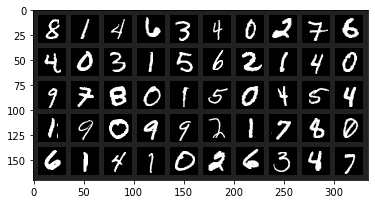

In [5]:
# Import libraries for visualising
import matplotlib.pyplot as plt
import numpy as np

# Load a batch of training images for visualising
data_iterator = iter(train_set_loader)
images, labels = data_iterator.next()

# Create function for visualisation
def show_image(img):
    # revert the normalisation when displaying the images
    img = img * 0.3081 + 0.1307
    # Convert to numpy for visualisation
    npimg = img.numpy()
    # Plot each image
    plt.imshow(np.transpose(npimg, (1, 2, 0)))


# Plot images as a grid using the 'make_grid' function
show_image(torchvision.utils.make_grid(images,10,5))
plt.show()

## Building a Convolutional Neural Network (CNN)



In [7]:
# Build the neural network using PyTorch
from torch.autograd import Variable
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
np.random.seed(3)

# Module is a base class for all neural network modules
class Neural_Network(nn.Module):
    
    # Define the neural network layers
    def __init__(self):
        
        super(Neural_Network, self).__init__()
        
        # Add the first convolutional layer. This is done using the Conv2d function.
        # The 1st parameter specifies the number of input channels.
        # The 2nd parameter specifies the number of output channels or filters.
        # The 3rd parameter specifies the size of the convolutional kernel.
        self.conv1 = nn.Conv2d(1, 10, kernel_size=5)
        
        # Add the second convolutional layer.
        self.conv2 = nn.Conv2d(10, 20, kernel_size=5)

        
        # Add the first fully connected layer. This is done using the Linear function.
        # The 1st parameter specifies the size of the input.
        # The 2nd parameter specifies the size of the output. 
        self.fc1 = nn.Linear(320, 50)
        
        # Add the second fully connected layer.   
        self.fc2 = nn.Linear(50, 10)
       
        
        # Costs and accuracy attributes 
        self.losses = []
        self.accuracies = []
     

    # Define the forward pass.    
    def forward(self, x):
        # Apply a 2D max pooling over the output of the 1st convolutional layer
        x = F.max_pool2d(self.conv1(x), 2)
        # Add a ReLU activation function to the 1st convolutional layer
        x = F.relu(x)
        #print(x.size())
        
        # Apply a 2D max pooling over the output of the 2nd convolutional layer
        x = F.max_pool2d(self.conv2(x), 2)
        # Add a ReLU activation function to the 2nd convolutional layer
        x = F.relu(x)
      
        
        # Flatten the output of the 2nd convolutional layer to feed into the next layer
        x = x.view(-1, 320)
        # Add a ReLU activation function to the 1st fully connected layer
        x = F.relu(self.fc1(x))
        # Add a log softmax activation function to the final layer
        x = F.log_softmax(self.fc2(x), dim=0)
     
        
        return x
     
    '''
    We start with an image of 28x28 pixels in the first convolutional layer, and then apply it to 10 filters of size 5. 
    The output of this is 10 channels of size 24x24.
    The pooling channel halves the output channels, giving 10 feature maps of 12x12.
    In the second convolutional layer, the input is 10 channels of of size 12x12. We apply 2 filters to each channel of size
    5. Therefore the output of this is 20 feature maps of size 8x8. 
    After pooling, we get 20 output features maps of size 4x4.
    At the end, theres 20x4x4 = 320 units for the first connected layer. 
    '''
    
    
    # Train the CNN
    def train_net(self, train_set, no_epochs, lr, m):
        
        # Define the loss function as the negative log likelihood loss
        loss_func = nn.NLLLoss()

        # Define the optimizer as stochastic gradient descent
        optimizer = optim.SGD(net.parameters(), lr = lr, momentum = m)

        # Loop over the number of epochs
        for epoch in range(no_epochs):

            # Reset the current loss and accuracy to zero 
            current_loss = 0.0
            current_accuracy = 0.0
            
            # Loop over each mini-batch
            for batch_index, training_batch in enumerate(train_set, 0):
                
                # Load the mini-batch
                inputs, labels = training_batch

                # Wrap the images as Variable
                inputs, labels = Variable(inputs), Variable(labels)

                # Set the parameter gradients to zero
                optimizer.zero_grad()

                # Propagate the inputs forward
                outputs = self.forward(inputs)
                
                # Calculate loss
                loss = loss_func(outputs, labels)
                
                # Propagate backward using the .backward() function
                loss.backward()
                
                # Update weights using the .step() function
                optimizer.step()

                # Add loss to the overall loss
                current_loss += loss.item()
                
                # Compute the accuracy of the current batch
                correct_pred = 0
                total_pred = 0
                for data in training_batch:
                    images, labels = training_batch
                    # Compute the predicted labels
                    outputs = self.forward(Variable(images))
                    dummy, pred_labels = torch.max(outputs.data, 1)
                    
                    # Count the correct predictions
                    correct_pred += (pred_labels == labels).sum().item()
                    total_pred += pred_labels.size(0)
                    
                # Add accuracy to the overall accuracy
                current_accuracy += (100 * correct_pred)/total_pred


                # Compute average batch loss and accuracy at every 300 batches 
                if batch_index % 300 == 299:
                    
                    # Display a message indicating where the training has reached
                    print('[Epoch: %d Batch: %5d] loss: %.3f' % 
                          (epoch + 1, batch_index+1, current_loss / 300)) 
                    # Append the average loss and accuracy
                    self.losses.append(current_loss/300)
                    self.accuracies.append(current_accuracy/300)
                    # Reset the current loss and accuracy for the next 300 batches
                    current_loss = 0.0
                    current_accuracy = 0.0


        # Display a message once the training has finished        
        print('Training has finished')

### Create and train a CNN

Now that we have defined the CNN, we can create a network and train it. 

In [8]:
# Create a neural network
net = Neural_Network()

# Set a number of epochs
no_epochs = 5
# Set the learning rate
lr = 0.001
# Set the momentum
momentum = 0.9

# Train the network using the parameter settings above
net.train_net(train_set_loader, no_epochs, lr, momentum)    

[Epoch: 1 Batch:   300] loss: 3.353
[Epoch: 1 Batch:   600] loss: 2.320
[Epoch: 1 Batch:   900] loss: 2.160
[Epoch: 1 Batch:  1200] loss: 2.077
[Epoch: 2 Batch:   300] loss: 2.013
[Epoch: 2 Batch:   600] loss: 1.976
[Epoch: 2 Batch:   900] loss: 1.952
[Epoch: 2 Batch:  1200] loss: 1.930
[Epoch: 3 Batch:   300] loss: 1.905
[Epoch: 3 Batch:   600] loss: 1.904
[Epoch: 3 Batch:   900] loss: 1.894
[Epoch: 3 Batch:  1200] loss: 1.891
[Epoch: 4 Batch:   300] loss: 1.869
[Epoch: 4 Batch:   600] loss: 1.869
[Epoch: 4 Batch:   900] loss: 1.863
[Epoch: 4 Batch:  1200] loss: 1.856
[Epoch: 5 Batch:   300] loss: 1.851
[Epoch: 5 Batch:   600] loss: 1.842
[Epoch: 5 Batch:   900] loss: 1.840
[Epoch: 5 Batch:  1200] loss: 1.831
Training has finished


### Visualize the training loss and accuracy

Once the training has finished, we can visualise the training accuracy and loss that we have computed in the `train_net` function as the average loss/accuracy after every 300 mini-batches.

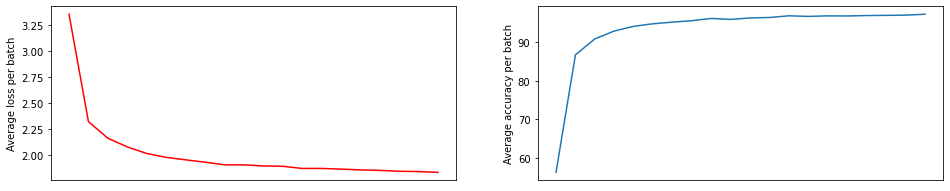

In [9]:
# Get the losses and accuracies
training_loss = net.losses
training_accuracy = net.accuracies

# Plots the loss and accuracy evolution during training 
fig = plt.figure(figsize=plt.figaspect(0.2))
ax1 = fig.add_subplot(1, 2, 1)
ax1.plot(training_loss,'r')
plt.ylabel('Average loss per batch')
ax1.axes.get_xaxis().set_ticks([])
ax1 = fig.add_subplot(1, 2, 2)
ax1.plot(training_accuracy)
plt.ylabel('Average accuracy per batch')
ax1.axes.get_xaxis().set_ticks([])
plt.show()

### Evaluate the CNN on the test set

Now we can see how our network performs on the test set. For this, we will compute the accuracy for the test set as well as the accuracy for each class in order to see whether the network performs better at recognising certain digits.

In [10]:
# Compute classification accuracy for the entire test set
correct_pred = 0
total_pred = 0

# Loop over the mini batches of the test set
for test_data in test_set_loader:
    test_images, test_labels = test_data
    # Compute the predictions
    outputs = net.forward(Variable(test_images))
    dummy, predicted_labels = torch.max(outputs.data, 1)
    # Count the correct predictions
    correct_pred += (predicted_labels == test_labels).sum()
    total_pred += predicted_labels.size(0)
       
print('Accuracy of the network on the 10,000 test images: %d %%' 
      % ( 100 * correct_pred / total_pred))

# Compute classification accuracy for each class
class_correct = list(0. for i in range(10))
class_total = list(0. for i in range(10))
# Loop over the mini batches of the test set
for test_data in test_set_loader:
    
    test_images, test_labels = test_data
    
    # Compute the predictions
    outputs = net.forward(Variable(test_images))
    dummy, pred_labels = torch.max(outputs.data, 1)
    
    # Count the correct predictions
    correct = (pred_labels == test_labels).squeeze()
    for i in range(10):
        label = test_labels[i]
        class_correct[label] += correct[i]
        class_total[label] +=1

for i in range(10):
    print('Accuracy of digit %d : %2d %%' % ( i, 
                                             100 * class_correct[i].item()/class_total[i]))
    

Accuracy of the network on the 10,000 test images: 97 %
Accuracy of digit 0 : 99 %
Accuracy of digit 1 : 96 %
Accuracy of digit 2 : 96 %
Accuracy of digit 3 : 96 %
Accuracy of digit 4 : 96 %
Accuracy of digit 5 : 97 %
Accuracy of digit 6 : 96 %
Accuracy of digit 7 : 98 %
Accuracy of digit 8 : 96 %
Accuracy of digit 9 : 93 %


### Visualize some example results

Finally, we can visualise some examples from the test set and compare the correct and the predicted labels.

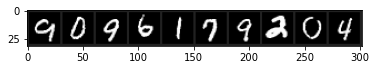

  Correct Label:      9     0     9     6     1     7     9     2     0     4
Predicted Label:      9     0     9     6     1     7     9     2     0     4


In [11]:
# Pick a random batch & extract the corect labels
data_iterator = iter(test_set_loader)
images, correct_labels = data_iterator.next()

# Compute the predicted label
outputs = net.forward(Variable(images))
dummy, predicted_labels = torch.max(outputs.data, 1)

# print images
show_image(torchvision.utils.make_grid(images[0:10], 10))
plt.show()
print('  Correct Label: ', ' '.join('%5s' % correct_labels[j].item() for j in range(10)))
print('Predicted Label: ', ' '.join('%5s' % predicted_labels[j].item() for j in range(10)))